### Phase 1-2: Data Collection and Preprocessing



In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Phase 1: Literature Review outcome - Data structure definitions
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the incident data from CSV file
    Parameters:
        file_path (str): Path to the incidents CSV file
    Returns:
        pd.DataFrame: Preprocessed monthly trends data
        list: Top 10 components by incident count
    """
    # Load data
    data = pd.read_csv(file_path)
    data['Creation Month'] = pd.to_datetime(data['Creation Month'], format='%Y-%m')
    
    # Group and aggregate data
    monthly_trends = data.groupby(['Creation Month', 'Component'])['Incident'].count().reset_index()
    component_growth = monthly_trends.groupby('Component')['Incident'].sum().reset_index()
    component_growth.columns = ['Component', 'Total Incidents']
    
    # Get top 10 components
    top_components = component_growth.nlargest(10, 'Total Incidents')['Component'].tolist()
    
    return monthly_trends, top_components

def prepare_component_data(monthly_trends, component, scaler=None):
    """
    Prepare time series data for a specific component
    Parameters:
        monthly_trends (pd.DataFrame): Monthly incident trends data
        component (str): Component name to analyze
        scaler (sklearn.preprocessing.MinMaxScaler, optional): Scaler for normalization
    Returns:
        pd.Series: Processed time series data
        sklearn.preprocessing.MinMaxScaler: Fitted scaler
    """
    # Filter data for current component
    component_data = monthly_trends[monthly_trends['Component'] == component]
    
    # Ensure complete monthly data
    date_range = pd.date_range(component_data['Creation Month'].min(),
                              component_data['Creation Month'].max(), 
                              freq='MS')
    component_data = component_data.set_index('Creation Month').reindex(date_range, fill_value=0)
    component_data.index.name = 'Creation Month'
    
    # Remove outliers using IQR
    q1 = component_data['Incident'].quantile(0.10)
    q3 = component_data['Incident'].quantile(0.90)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    component_data = component_data[(component_data['Incident'] >= lower_bound) &
                                  (component_data['Incident'] <= upper_bound)]
    
    # Apply moving average smoothing
    component_data['Smoothed_Incident'] = component_data['Incident'].rolling(window=3, center=True).mean()
    component_data['Incident'].fillna(component_data['Smoothed_Incident'], inplace=True)
    
    # Scale the data
    if scaler is None:
        scaler = MinMaxScaler()
    component_data['Scaled Incident'] = scaler.fit_transform(component_data[['Incident']])
    
    return component_data['Scaled Incident'], scaler

### Phase 3: Framework Design and Model Selection



In [25]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller, acf, pacf

def check_overfitting_metrics(train_data, val_data, test_data, predictions_train, predictions_val, predictions_test):
    """
    Calculate metrics to detect overfitting
    Parameters:
        train_data, val_data, test_data: Actual values for each dataset
        predictions_train, predictions_val, predictions_test: Predicted values for each dataset
    Returns:
        dict: Dictionary containing overfitting metrics and status
    """
    train_mae = mean_absolute_error(train_data, predictions_train)
    val_mae = mean_absolute_error(val_data, predictions_val)
    test_mae = mean_absolute_error(test_data, predictions_test)
    
    # Calculate ratios
    val_train_ratio = val_mae / train_mae if train_mae > 0 else float('inf')
    test_train_ratio = test_mae / train_mae if train_mae > 0 else float('inf')
    
    # Determine overfitting status
    if val_train_ratio > 2 or test_train_ratio > 2:
        status = "High risk of overfitting"
    elif val_train_ratio > 1.5 or test_train_ratio > 1.5:
        status = "Moderate risk of overfitting"
    else:
        status = "Low risk of overfitting"
        
    return {
        'train_mae': train_mae,
        'val_mae': val_mae,
        'test_mae': test_mae,
        'val_train_ratio': val_train_ratio,
        'test_train_ratio': test_train_ratio,
        'status': status
    }

def calculate_accuracy_metrics(actual, predicted):
    """
    Calculate comprehensive accuracy metrics
    Parameters:
        actual: Actual values
        predicted: Predicted values
    Returns:
        dict: Dictionary containing various accuracy metrics
    """
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'SMAPE': smape
    }

def calculate_weights(hw_val_mae, arima_val_mae):
    """
    Calculate weights for combined forecast based on validation performance
    Parameters:
        hw_val_mae: Validation MAE for Holt-Winters model
        arima_val_mae: Validation MAE for ARIMA model
    Returns:
        tuple: (hw_weight, arima_weight)
    """
    total_error = hw_val_mae + arima_val_mae
    hw_weight = 1 - (hw_val_mae / total_error)
    arima_weight = 1 - (arima_val_mae / total_error)
    
    # Normalize weights
    total_weight = hw_weight + arima_weight
    hw_weight = hw_weight / total_weight
    arima_weight = arima_weight / total_weight
    
    return hw_weight, arima_weight

def check_stationarity(data):
    """
    Check if time series is stationary using Augmented Dickey-Fuller test
    Parameters:
        data: Time series data
    Returns:
        bool: True if stationary, False otherwise
    """
    result = adfuller(data.dropna())
    return result[1] < 0.05

def get_optimal_arima_orders(train_data):
    """
    Get optimal ARIMA orders based on ACF and PACF analysis
    Parameters:
        train_data: Training data
    Returns:
        tuple: (p, q) orders for ARIMA model
    """
    acf_values = acf(train_data, nlags=min(20, len(train_data) // 2))
    pacf_values = pacf(train_data, nlags=min(20, len(train_data) // 2))
    
    p = np.where(np.abs(pacf_values) > 0.2)[0][-1] if len(np.where(np.abs(pacf_values) > 0.2)[0]) > 0 else 1
    q = np.where(np.abs(acf_values) > 0.2)[0][-1] if len(np.where(np.abs(acf_values) > 0.2)[0]) > 0 else 1
    return min(p, 5), min(q, 5)

### Phase 4: Model Training and Optimization



In [26]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

def train_holtwinters_model(train_data, seasonal_periods=[3, 6, 12]):
    """
    Train and optimize Holt-Winters model
    Parameters:
        train_data: Training data
        seasonal_periods: List of seasonal periods to try
    Returns:
        tuple: (best_model, best_mae)
    """
    hw_best_mae = float('inf')
    hw_best_model = None
    
    for sp in seasonal_periods:
        for trend in ['add', 'mul']:
            for seasonal in ['add', 'mul']:
                try:
                    model = ExponentialSmoothing(
                        train_data,
                        trend=trend,
                        seasonal=seasonal,
                        seasonal_periods=sp,
                        damped=True
                    ).fit(optimized=True)
                    
                    forecast = model.forecast(len(train_data))
                    mae = mean_absolute_error(train_data, forecast)
                    
                    if mae < hw_best_mae:
                        hw_best_mae = mae
                        hw_best_model = model
                except:
                    continue
    
    return hw_best_model, hw_best_mae

def train_arima_model(train_data, p_optimal, q_optimal):
    """
    Train and optimize ARIMA model
    Parameters:
        train_data: Training data
        p_optimal, q_optimal: Optimal ARIMA orders
    Returns:
        tuple: (best_model, best_mae)
    """
    arima_best_mae = float('inf')
    arima_best_model = None
    
    for i in range(p_optimal + 1):
        for d in range(2):
            for j in range(q_optimal + 1):
                try:
                    model = ARIMA(train_data, order=(i, d, j)).fit()
                    forecast = model.forecast(steps=len(train_data))
                    mae = mean_absolute_error(train_data, forecast)
                    if mae < arima_best_mae:
                        arima_best_mae = mae
                        arima_best_model = model
                except:
                    continue
    
    return arima_best_model, arima_best_mae

def train_prophet_model(train_data):
    """
    Train and optimize Prophet model
    Parameters:
        train_data: Training data in Prophet format
    Returns:
        tuple: (best_model, best_mae)
    """
    prophet_best_mae = float('inf')
    prophet_best_model = None
    
    changepoint_priors = [0.05, 0.1, 0.2]
    for prior in changepoint_priors:
        for yearly_seasonality in [True, False]:
            try:
                model = Prophet(
                    yearly_seasonality=yearly_seasonality,
                    daily_seasonality=False,
                    changepoint_prior_scale=prior,
                    seasonality_prior_scale=10,
                )
                model.add_seasonality(name='quarterly', period=90, fourier_order=5)
                model.fit(train_data)
                
                forecast = model.predict(train_data)
                mae = mean_absolute_error(train_data['y'].values, forecast['yhat'].values)
                
                if mae < prophet_best_mae:
                    prophet_best_mae = mae
                    prophet_best_model = model
            except:
                continue
    
    return prophet_best_model, prophet_best_mae

### Phase 5: Model Validation



In [27]:
import matplotlib.pyplot as plt

def validate_and_visualize_models(time_series_data, train_data, test_data, 
                                hw_forecast, arima_forecast, combined_forecast, 
                                prophet_overlap=None, component_name=None):
    """
    Validate models and create visualization
    Parameters:
        time_series_data: Complete time series data
        train_data, test_data: Training and test datasets
        hw_forecast, arima_forecast, combined_forecast: Model forecasts
        prophet_overlap: Prophet model forecast (optional)
        component_name: Name of the component being analyzed
    """
    plt.figure(figsize=(15, 8))
    plt.plot(time_series_data.index, time_series_data, 
             label='Historic Data', marker='o', markersize=4, color='blue', alpha=0.6)
    plt.plot(hw_forecast.index, hw_forecast, 
             label='Holt-Winters Forecast', linestyle='--', marker='o', markersize=4, color='orange')
    plt.plot(test_data.index, arima_forecast, 
             label='ARIMA Forecast', linestyle='--', marker='o', markersize=4, color='green')
    plt.plot(test_data.index, combined_forecast, 
             label='Combined Forecast', linestyle='--', marker='o', markersize=4, color='purple')
    
    if prophet_overlap is not None:
        plt.plot(test_data.index, prophet_overlap.values, 
                label='Prophet Forecast', linestyle='--', marker='o', markersize=4, color='red')
    
    plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label='Train/Test Split')
    title = 'Forecast Comparison'
    if component_name:
        title += f' for Component: {component_name}'
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Creation Month', fontsize=12)
    plt.ylabel('Scaled Number of Incidents', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_validation_results(component_name, hw_metrics, arima_metrics, combined_metrics, 
                           hw_accuracy, arima_accuracy, combined_accuracy, 
                           hw_weight, arima_weight, prophet_metrics=None, prophet_accuracy=None):
    """
    Print comprehensive validation results
    Parameters:
        component_name: Name of the component being analyzed
        *metrics: Overfitting metrics for each model
        *accuracy: Accuracy metrics for each model
        hw_weight, arima_weight: Model weights for combined forecast
        prophet_metrics, prophet_accuracy: Prophet model metrics (optional)
    """
    print(f"\nValidation Results for Component: {component_name}")
    print("="*80)
    
    print("\nModel Weights in Combined Forecast:")
    print(f"Holt-Winters Weight: {hw_weight:.4f}")
    print(f"ARIMA Weight: {arima_weight:.4f}")
    
    print("\nAccuracy Metrics:")
    
    def print_model_metrics(name, accuracy, metrics):
        print(f"\n{name} Model:")
        print(f"MSE: {accuracy['MSE']:.4f}")
        print(f"RMSE: {accuracy['RMSE']:.4f}")
        print(f"MAE: {accuracy['MAE']:.4f}")
        print(f"MAPE: {accuracy['MAPE']:.4f}%")
        print(f"SMAPE: {accuracy['SMAPE']:.4f}%")
        print(f"\nOverfitting Analysis:")
        print(f"Train MAE: {metrics['train_mae']:.4f}")
        print(f"Validation MAE: {metrics['val_mae']:.4f}")
        print(f"Test MAE: {metrics['test_mae']:.4f}")
        print(f"Validation/Train Ratio: {metrics['val_train_ratio']:.4f}")
        print(f"Test/Train Ratio: {metrics['test_train_ratio']:.4f}")
        print(f"Status: {metrics['status']}")
    
    print_model_metrics("Holt-Winters", hw_accuracy, hw_metrics)
    print_model_metrics("ARIMA", arima_accuracy, arima_metrics)
    print_model_metrics("Combined", combined_accuracy, combined_metrics)
    
    if prophet_metrics is not None and prophet_accuracy is not None:
        print_model_metrics("Prophet", prophet_accuracy, prophet_metrics)

def store_validation_results(component, hw_best_model, arima_best_model, prophet_best_model,
                           hw_weight, arima_weight, hw_forecast, arima_forecast, prophet_overlap,
                           combined_forecast, hw_metrics, arima_metrics, prophet_metrics,
                           combined_metrics, hw_accuracy, arima_accuracy, prophet_accuracy,
                           combined_accuracy):
    """
    Store validation results for a component
    Parameters:
        component: Component name
        *args: Various model parameters and metrics
    Returns:
        dict: Structured results dictionary
    """
    results = {
        'best_model': {
            'hw_model': hw_best_model,
            'arima_model': arima_best_model,
            'prophet_model': prophet_best_model if prophet_best_model is not None else None,
            'weights': {
                'hw_weight': hw_weight,
                'arima_weight': arima_weight
            }
        },
        'forecasts': {
            'hw_forecast': hw_forecast,
            'arima_forecast': arima_forecast,
            'prophet_forecast': prophet_overlap if prophet_best_model is not None else None,
            'combined_forecast': combined_forecast
        },
        'metrics': {
            'hw_metrics': hw_metrics,
            'arima_metrics': arima_metrics,
            'prophet_metrics': prophet_metrics if prophet_best_model is not None else None,
            'combined_metrics': combined_metrics
        },
        'accuracy': {
            'hw_accuracy': hw_accuracy,
            'arima_accuracy': arima_accuracy,
            'prophet_accuracy': prophet_accuracy if prophet_best_model is not None else None,
            'combined_accuracy': combined_accuracy
        }
    }
    return results

### Main Execution Script





Analyzing Component: XX-S4C-OPR-SRV


16:42:30 - cmdstanpy - INFO - Chain [1] start processing
16:42:30 - cmdstanpy - INFO - Chain [1] done processing
16:42:30 - cmdstanpy - INFO - Chain [1] start processing
16:42:30 - cmdstanpy - INFO - Chain [1] done processing
16:42:30 - cmdstanpy - INFO - Chain [1] start processing
16:42:30 - cmdstanpy - INFO - Chain [1] done processing
16:42:30 - cmdstanpy - INFO - Chain [1] start processing
16:42:30 - cmdstanpy - INFO - Chain [1] done processing
16:42:30 - cmdstanpy - INFO - Chain [1] start processing
16:42:31 - cmdstanpy - INFO - Chain [1] done processing
16:42:31 - cmdstanpy - INFO - Chain [1] start processing
16:42:31 - cmdstanpy - INFO - Chain [1] done processing


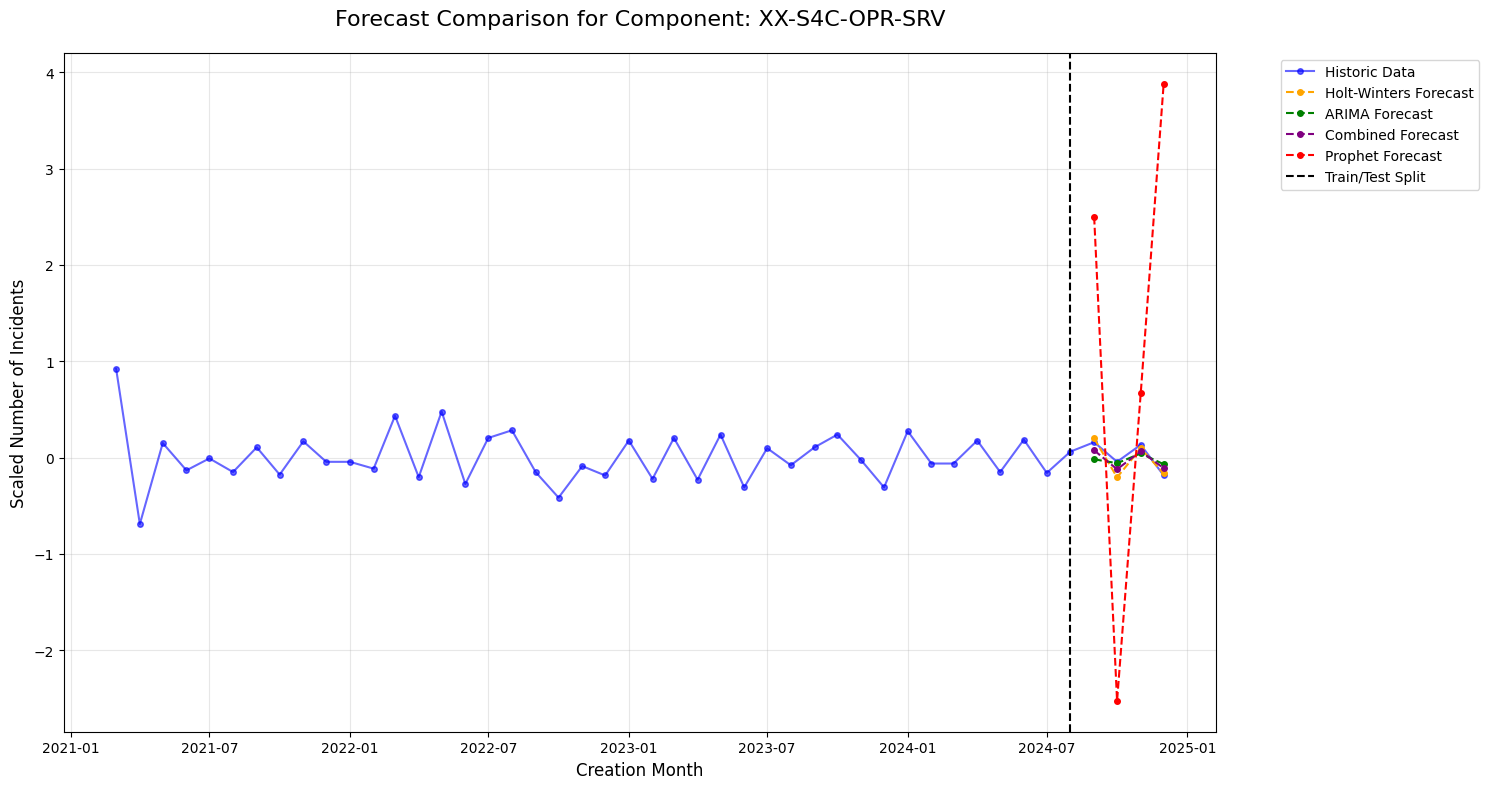


Validation Results for Component: XX-S4C-OPR-SRV

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4282
ARIMA Weight: 0.5718

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0073
RMSE: 0.0855
MAE: 0.0647
MAPE: 106.9041%
SMAPE: 49.0397%

Overfitting Analysis:
Train MAE: 0.3406
Validation MAE: 0.2000
Test MAE: 0.0647
Validation/Train Ratio: 0.5872
Test/Train Ratio: 0.1899
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0133
RMSE: 0.1153
MAE: 0.0994
MAPE: 68.5410%
SMAPE: 105.3592%

Overfitting Analysis:
Train MAE: 0.3588
Validation MAE: 0.1498
Test MAE: 0.0994
Validation/Train Ratio: 0.4175
Test/Train Ratio: 0.2772
Status: Low risk of overfitting

Combined Model:
MSE: 0.0058
RMSE: 0.0764
MAE: 0.0761
MAPE: 79.6817%
SMAPE: 71.1008%

Overfitting Analysis:
Train MAE: 0.3440
Validation MAE: 0.1670
Test MAE: 0.0761
Validation/Train Ratio: 0.4856
Test/Train Ratio: 0.2213
Status: Low risk of overfitting

Prophet Model:
MSE: 7.1209
RMSE: 2.6685
MAE: 2.3575
MAPE: nan%
SMAPE: nan%

Ove

16:42:36 - cmdstanpy - INFO - Chain [1] start processing
16:42:36 - cmdstanpy - INFO - Chain [1] done processing
16:42:36 - cmdstanpy - INFO - Chain [1] start processing
16:42:36 - cmdstanpy - INFO - Chain [1] done processing
16:42:36 - cmdstanpy - INFO - Chain [1] start processing
16:42:36 - cmdstanpy - INFO - Chain [1] done processing
16:42:36 - cmdstanpy - INFO - Chain [1] start processing
16:42:36 - cmdstanpy - INFO - Chain [1] done processing
16:42:36 - cmdstanpy - INFO - Chain [1] start processing
16:42:36 - cmdstanpy - INFO - Chain [1] done processing
16:42:36 - cmdstanpy - INFO - Chain [1] start processing
16:42:36 - cmdstanpy - INFO - Chain [1] done processing


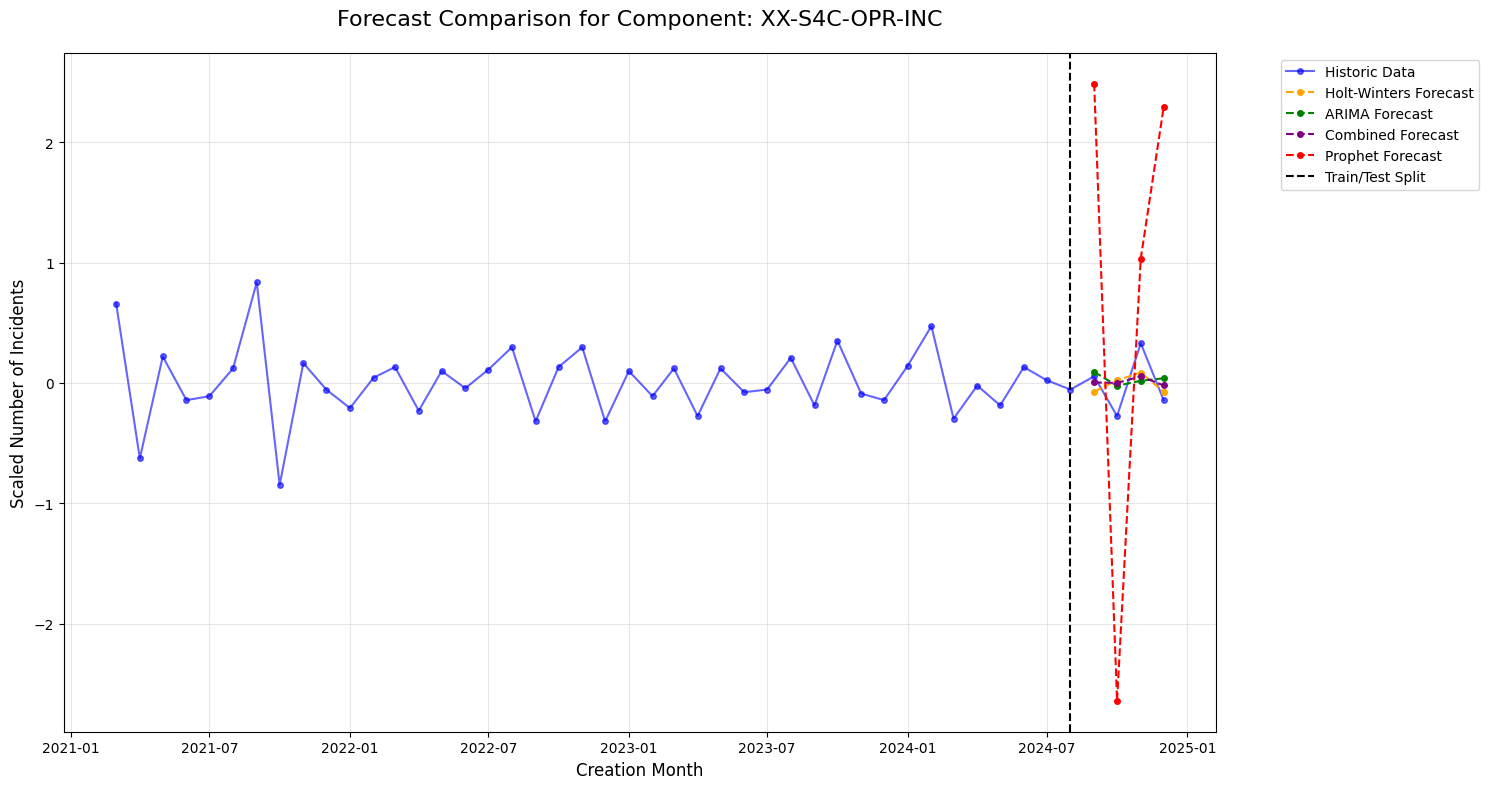


Validation Results for Component: XX-S4C-OPR-INC

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.5303
ARIMA Weight: 0.4697

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0420
RMSE: 0.2049
MAE: 0.1842
MAPE: 115.9202%
SMAPE: 145.2344%

Overfitting Analysis:
Train MAE: 0.2006
Validation MAE: 0.1523
Test MAE: 0.1842
Validation/Train Ratio: 0.7592
Test/Train Ratio: 0.9182
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0486
RMSE: 0.2204
MAE: 0.1953
MAPE: 95.0816%
SMAPE: 149.3751%

Overfitting Analysis:
Train MAE: 0.2827
Validation MAE: 0.1720
Test MAE: 0.1953
Validation/Train Ratio: 0.6082
Test/Train Ratio: 0.6906
Status: Low risk of overfitting

Combined Model:
MSE: 0.0422
RMSE: 0.2054
MAE: 0.1807
MAPE: 90.3082%
SMAPE: 165.9583%

Overfitting Analysis:
Train MAE: 0.2261
Validation MAE: 0.1615
Test MAE: 0.1807
Validation/Train Ratio: 0.7145
Test/Train Ratio: 0.7993
Status: Low risk of overfitting

Prophet Model:
MSE: 4.4810
RMSE: 2.1168
MAE: 1.9834
MAPE: nan%
SMAPE: nan%

O

16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:41 - cmdstanpy - INFO - Chain [1] done processing
16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:41 - cmdstanpy - INFO - Chain [1] done processing
16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:41 - cmdstanpy - INFO - Chain [1] done processing
16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:41 - cmdstanpy - INFO - Chain [1] done processing
16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:42 - cmdstanpy - INFO - Chain [1] done processing
16:42:42 - cmdstanpy - INFO - Chain [1] start processing
16:42:42 - cmdstanpy - INFO - Chain [1] done processing


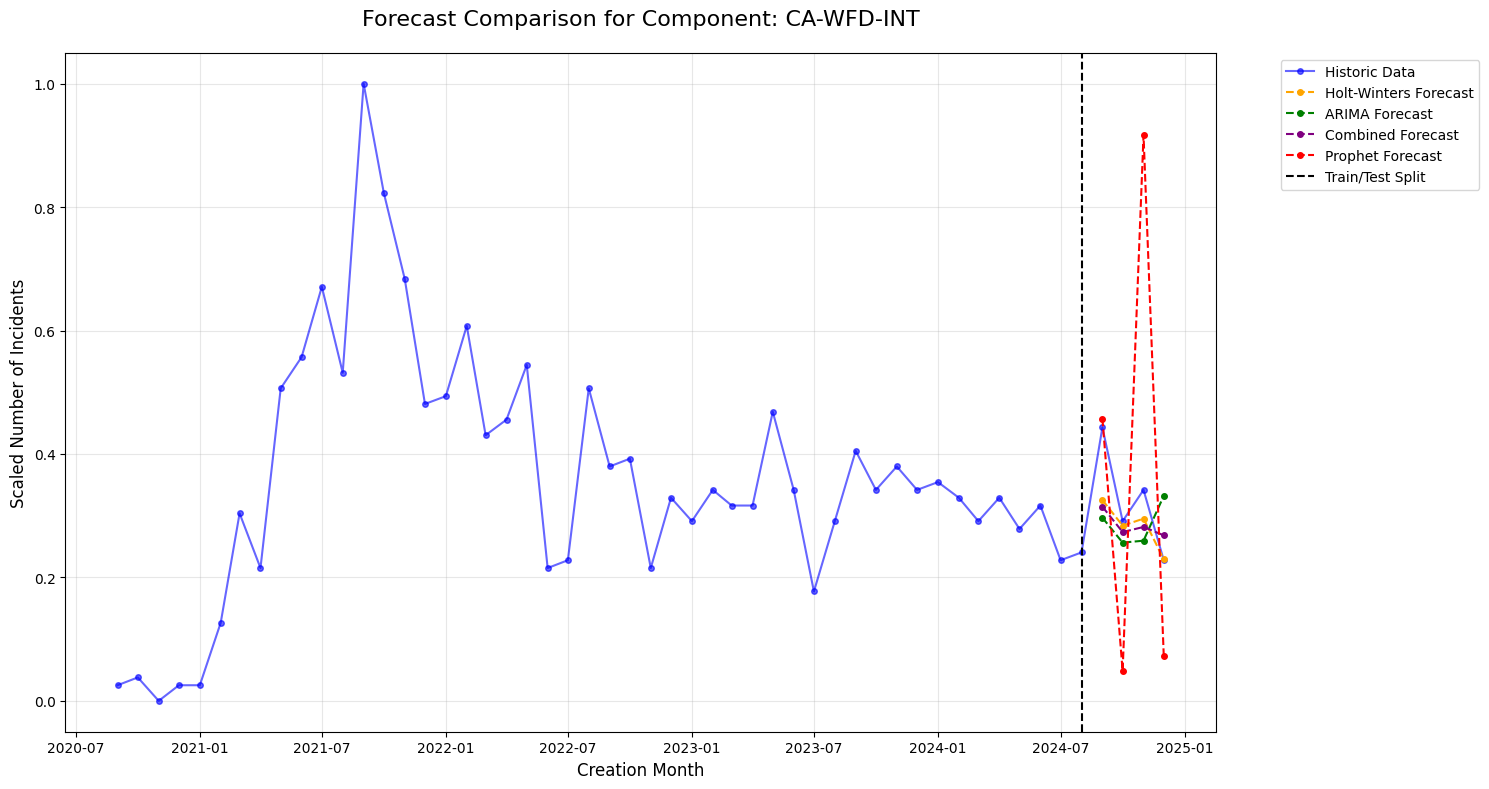


Validation Results for Component: CA-WFD-INT

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.6228
ARIMA Weight: 0.3772

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0040
RMSE: 0.0634
MAE: 0.0433
MAPE: 10.8382%
SMAPE: 12.1116%

Overfitting Analysis:
Train MAE: 0.2322
Validation MAE: 0.0595
Test MAE: 0.0433
Validation/Train Ratio: 0.2562
Test/Train Ratio: 0.1863
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0101
RMSE: 0.1003
MAE: 0.0919
MAPE: 28.6993%
SMAPE: 29.2143%

Overfitting Analysis:
Train MAE: 0.2259
Validation MAE: 0.0982
Test MAE: 0.0919
Validation/Train Ratio: 0.4347
Test/Train Ratio: 0.4068
Status: Low risk of overfitting

Combined Model:
MSE: 0.0055
RMSE: 0.0742
MAE: 0.0616
MAPE: 17.5759%
SMAPE: 18.9164%

Overfitting Analysis:
Train MAE: 0.2276
Validation MAE: 0.0548
Test MAE: 0.0616
Validation/Train Ratio: 0.2408
Test/Train Ratio: 0.2707
Status: Low risk of overfitting

Prophet Model:
MSE: 0.1033
RMSE: 0.3214
MAE: 0.2465
MAPE: nan%
SMAPE: nan%

Overfitti

16:42:46 - cmdstanpy - INFO - Chain [1] start processing
16:42:46 - cmdstanpy - INFO - Chain [1] done processing
16:42:46 - cmdstanpy - INFO - Chain [1] start processing
16:42:46 - cmdstanpy - INFO - Chain [1] done processing
16:42:46 - cmdstanpy - INFO - Chain [1] start processing
16:42:47 - cmdstanpy - INFO - Chain [1] done processing
16:42:47 - cmdstanpy - INFO - Chain [1] start processing
16:42:47 - cmdstanpy - INFO - Chain [1] done processing
16:42:47 - cmdstanpy - INFO - Chain [1] start processing
16:42:47 - cmdstanpy - INFO - Chain [1] done processing
16:42:47 - cmdstanpy - INFO - Chain [1] start processing
16:42:47 - cmdstanpy - INFO - Chain [1] done processing


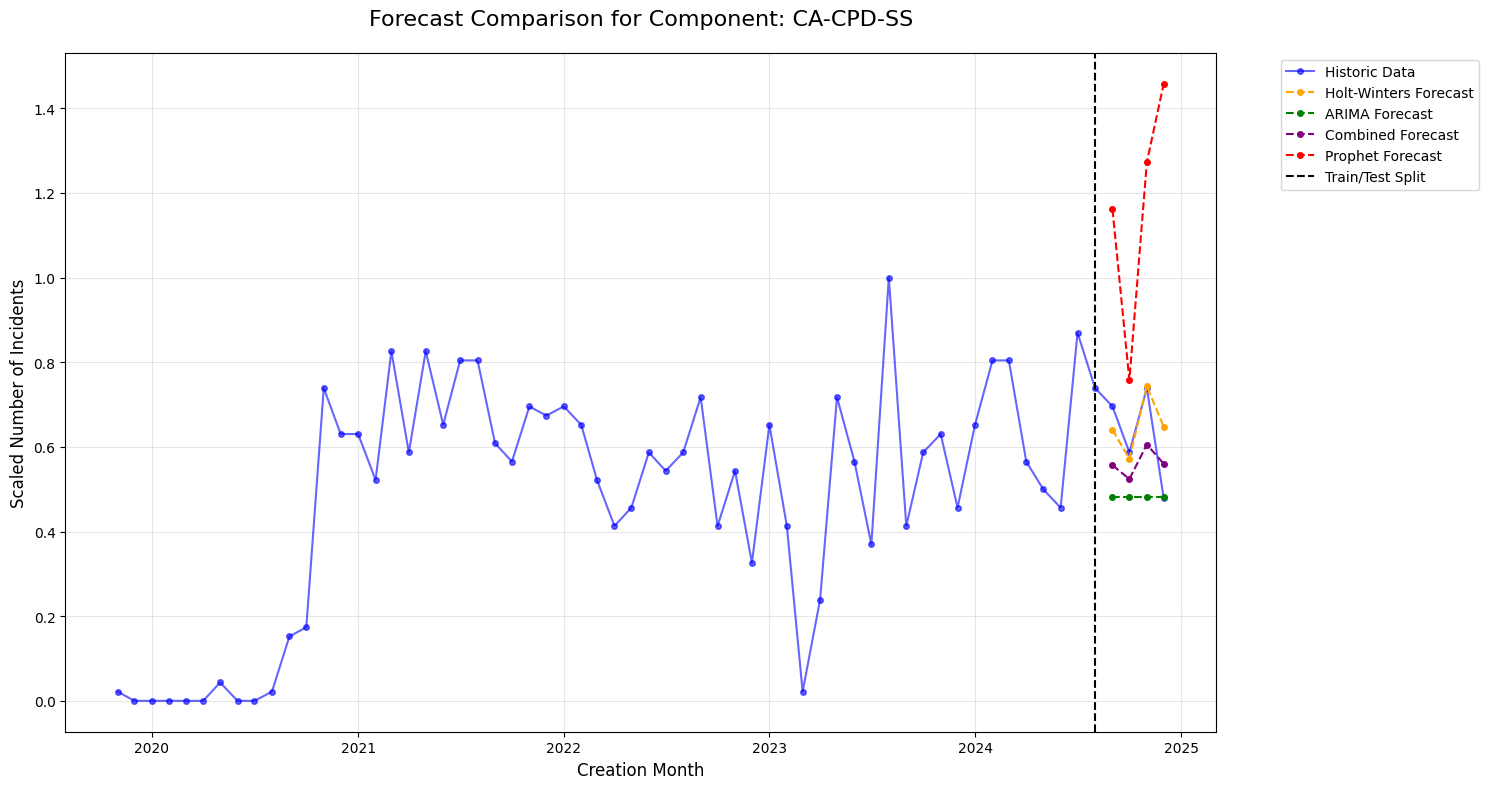


Validation Results for Component: CA-CPD-SS

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4752
ARIMA Weight: 0.5248

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0080
RMSE: 0.0894
MAE: 0.0610
MAPE: 11.6330%
SMAPE: 10.3921%

Overfitting Analysis:
Train MAE: 0.3122
Validation MAE: 0.2116
Test MAE: 0.0610
Validation/Train Ratio: 0.6779
Test/Train Ratio: 0.1955
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0310
RMSE: 0.1761
MAE: 0.1454
MAPE: 21.1083%
SMAPE: 24.8147%

Overfitting Analysis:
Train MAE: 0.2502
Validation MAE: 0.1916
Test MAE: 0.1454
Validation/Train Ratio: 0.7659
Test/Train Ratio: 0.5814
Status: Low risk of overfitting

Combined Model:
MSE: 0.0119
RMSE: 0.1093
MAE: 0.1043
MAPE: 16.4669%
SMAPE: 17.2838%

Overfitting Analysis:
Train MAE: 0.2714
Validation MAE: 0.1832
Test MAE: 0.1043
Validation/Train Ratio: 0.6750
Test/Train Ratio: 0.3843
Status: Low risk of overfitting

Prophet Model:
MSE: 0.3726
RMSE: 0.6104
MAE: 0.5373
MAPE: nan%
SMAPE: nan%

Overfittin

16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing
16:42:52 - cmdstanpy - INFO - Chain [1] start processing
16:42:52 - cmdstanpy - INFO - Chain [1] done processing


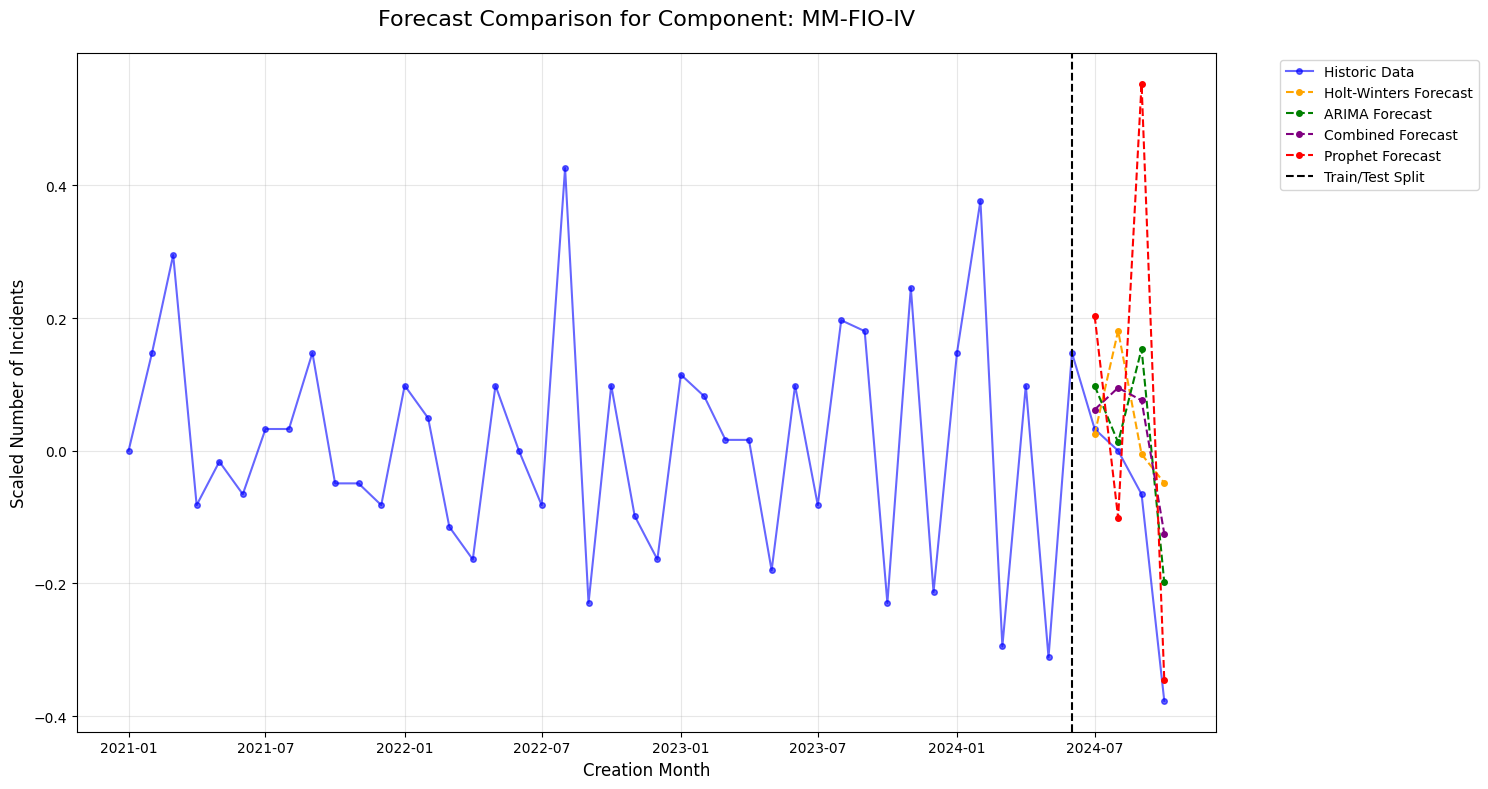


Validation Results for Component: MM-FIO-IV

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4896
ARIMA Weight: 0.5104

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0361
RMSE: 0.1900
MAE: 0.1445
MAPE: inf%
SMAPE: 138.4117%

Overfitting Analysis:
Train MAE: 0.1417
Validation MAE: 0.2062
Test MAE: 0.1445
Validation/Train Ratio: 1.4550
Test/Train Ratio: 1.0195
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0211
RMSE: 0.1452
MAE: 0.1189
MAPE: inf%
SMAPE: 140.4237%

Overfitting Analysis:
Train MAE: 0.1441
Validation MAE: 0.1978
Test MAE: 0.1189
Validation/Train Ratio: 1.3729
Test/Train Ratio: 0.8251
Status: Low risk of overfitting

Combined Model:
MSE: 0.0233
RMSE: 0.1528
MAE: 0.1294
MAPE: inf%
SMAPE: 140.5050%

Overfitting Analysis:
Train MAE: 0.1279
Validation MAE: 0.1950
Test MAE: 0.1294
Validation/Train Ratio: 1.5245
Test/Train Ratio: 1.0119
Status: Moderate risk of overfitting

Prophet Model:
MSE: 0.1058
RMSE: 0.3253
MAE: 0.2305
MAPE: nan%
SMAPE: nan%

Overfitting An

16:42:54 - cmdstanpy - INFO - Chain [1] start processing
16:42:54 - cmdstanpy - INFO - Chain [1] done processing
16:42:54 - cmdstanpy - INFO - Chain [1] start processing
16:42:54 - cmdstanpy - INFO - Chain [1] done processing
16:42:54 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing
16:42:55 - cmdstanpy - INFO - Chain [1] start processing
16:42:55 - cmdstanpy - INFO - Chain [1] done processing


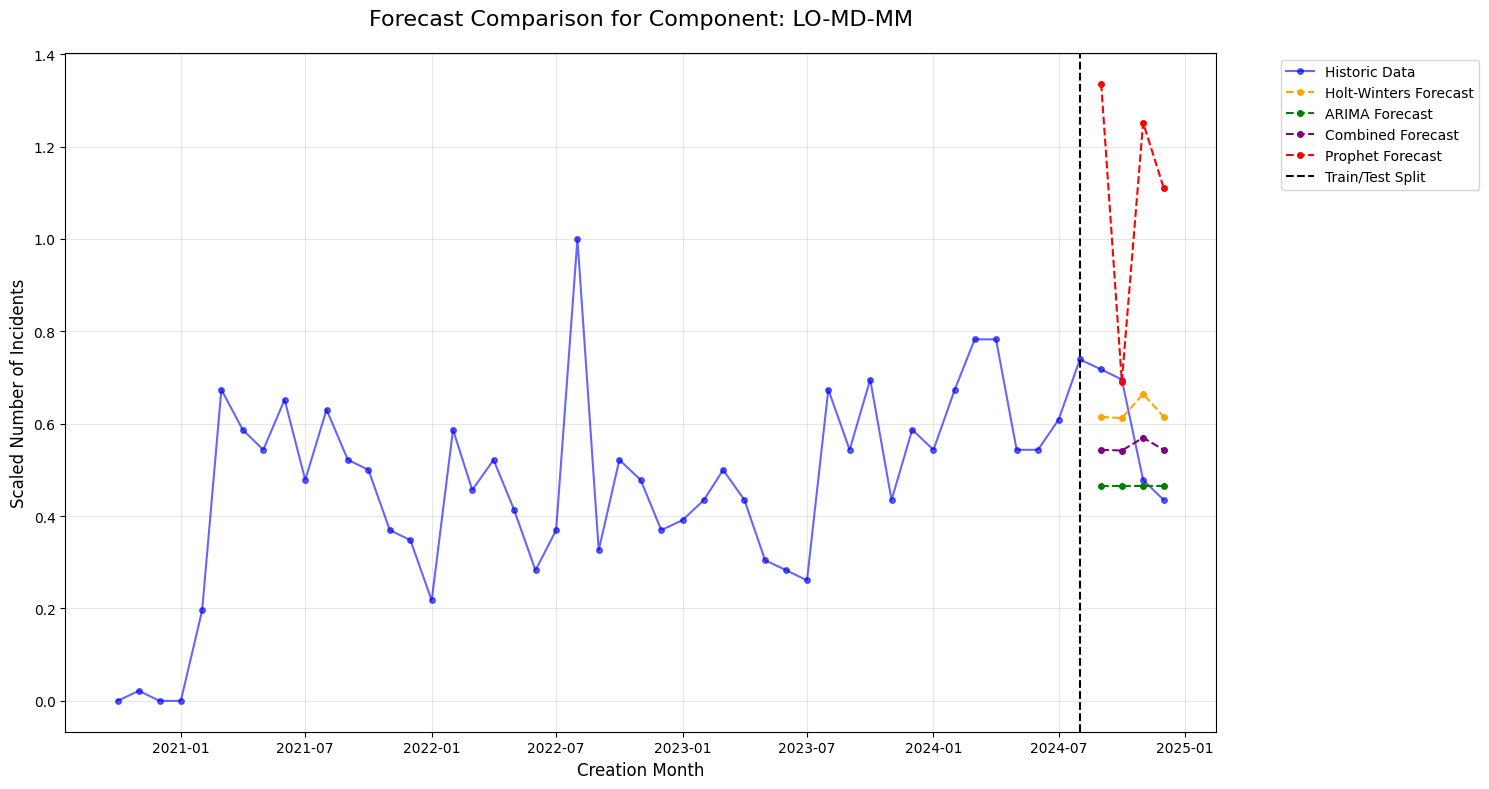


Validation Results for Component: LO-MD-MM

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.5254
ARIMA Weight: 0.4746

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0211
RMSE: 0.1454
MAE: 0.1381
MAPE: 26.6640%
SMAPE: 23.7708%

Overfitting Analysis:
Train MAE: 0.1891
Validation MAE: 0.1461
Test MAE: 0.1381
Validation/Train Ratio: 0.7728
Test/Train Ratio: 0.7305
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0296
RMSE: 0.1722
MAE: 0.1319
MAPE: 19.5559%
SMAPE: 23.0552%

Overfitting Analysis:
Train MAE: 0.1643
Validation MAE: 0.1617
Test MAE: 0.1319
Validation/Train Ratio: 0.9844
Test/Train Ratio: 0.8031
Status: Low risk of overfitting

Combined Model:
MSE: 0.0185
RMSE: 0.1360
MAE: 0.1319
MAPE: 22.6015%
SMAPE: 23.0156%

Overfitting Analysis:
Train MAE: 0.1750
Validation MAE: 0.1309
Test MAE: 0.1319
Validation/Train Ratio: 0.7479
Test/Train Ratio: 0.7537
Status: Low risk of overfitting

Prophet Model:
MSE: 0.3592
RMSE: 0.5994
MAE: 0.5179
MAPE: nan%
SMAPE: nan%

Overfitting

16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing
16:43:00 - cmdstanpy - INFO - Chain [1] start processing
16:43:00 - cmdstanpy - INFO - Chain [1] done processing
16:43:01 - cmdstanpy - INFO - Chain [1] start processing
16:43:01 - cmdstanpy - INFO - Chain [1] done processing
16:43:01 - cmdstanpy - INFO - Chain [1] start processing
16:43:01 - cmdstanpy - INFO - Chain [1] done processing
16:43:01 - cmdstanpy - INFO - Chain [1] start processing
16:43:01 - cmdstanpy - INFO - Chain [1] done processing
16:43:01 - cmdstanpy - INFO - Chain [1] start processing
16:43:01 - cmdstanpy - INFO - Chain [1] done processing


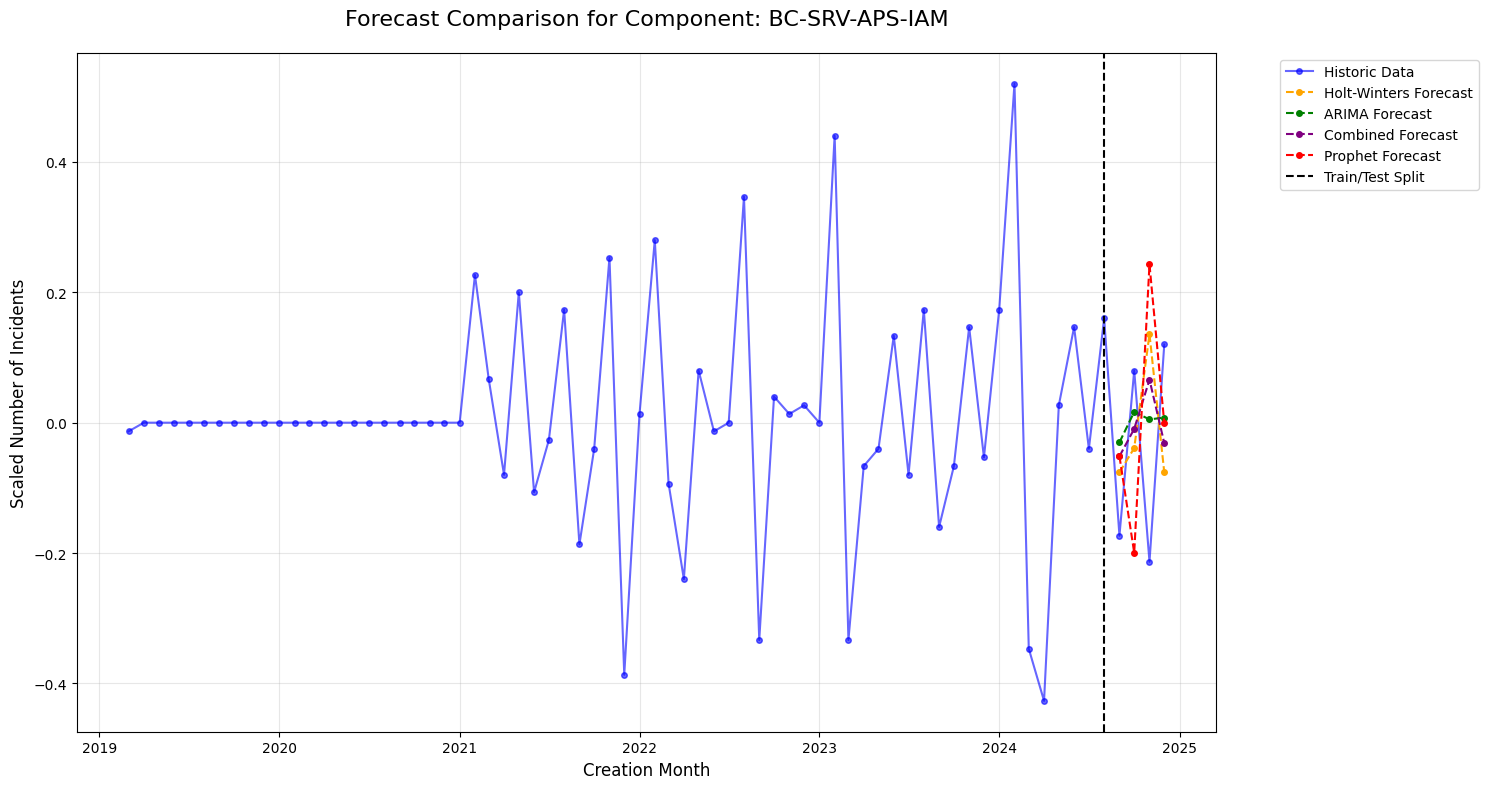


Validation Results for Component: BC-SRV-APS-IAM

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4667
ARIMA Weight: 0.5333

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0460
RMSE: 0.2144
MAE: 0.1903
MAPE: 132.9761%
SMAPE: 169.4670%

Overfitting Analysis:
Train MAE: 0.1450
Validation MAE: 0.1810
Test MAE: 0.1903
Validation/Train Ratio: 1.2482
Test/Train Ratio: 1.3123
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0212
RMSE: 0.1456
MAE: 0.1343
MAPE: 89.4412%
SMAPE: 161.9262%

Overfitting Analysis:
Train MAE: 0.0874
Validation MAE: 0.1584
Test MAE: 0.1343
Validation/Train Ratio: 1.8120
Test/Train Ratio: 1.5359
Status: Moderate risk of overfitting

Combined Model:
MSE: 0.0309
RMSE: 0.1759
MAE: 0.1604
MAPE: 109.7580%
SMAPE: 177.0343%

Overfitting Analysis:
Train MAE: 0.1065
Validation MAE: 0.1651
Test MAE: 0.1604
Validation/Train Ratio: 1.5505
Test/Train Ratio: 1.5066
Status: Moderate risk of overfitting

Prophet Model:
MSE: 0.0789
RMSE: 0.2808
MAE: 0.2445
MAPE: nan%
SMA

16:43:05 - cmdstanpy - INFO - Chain [1] start processing
16:43:05 - cmdstanpy - INFO - Chain [1] done processing
16:43:05 - cmdstanpy - INFO - Chain [1] start processing
16:43:05 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing
16:43:06 - cmdstanpy - INFO - Chain [1] start processing
16:43:06 - cmdstanpy - INFO - Chain [1] done processing


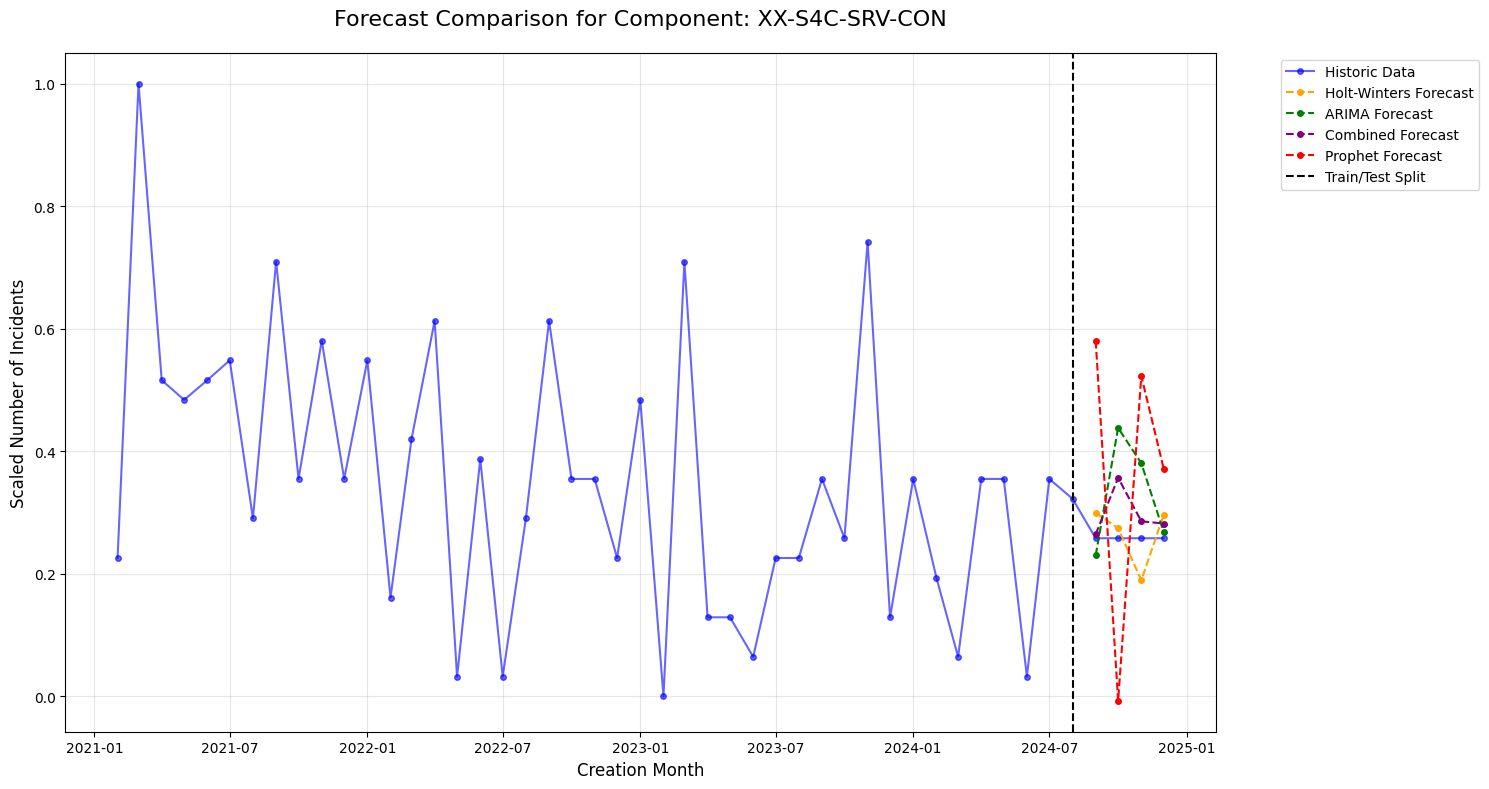


Validation Results for Component: XX-S4C-SRV-CON

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4963
ARIMA Weight: 0.5037

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0020
RMSE: 0.0452
MAE: 0.0412
MAPE: 15.9470%
SMAPE: 16.3653%

Overfitting Analysis:
Train MAE: 0.1821
Validation MAE: 0.1452
Test MAE: 0.0412
Validation/Train Ratio: 0.7974
Test/Train Ratio: 0.2260
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0121
RMSE: 0.1099
MAE: 0.0851
MAPE: 32.9606%
SMAPE: 26.3116%

Overfitting Analysis:
Train MAE: 0.2080
Validation MAE: 0.1431
Test MAE: 0.0851
Validation/Train Ratio: 0.6878
Test/Train Ratio: 0.4089
Status: Low risk of overfitting

Combined Model:
MSE: 0.0028
RMSE: 0.0528
MAE: 0.0392
MAPE: 15.1928%
SMAPE: 13.4085%

Overfitting Analysis:
Train MAE: 0.1879
Validation MAE: 0.1260
Test MAE: 0.0392
Validation/Train Ratio: 0.6703
Test/Train Ratio: 0.2086
Status: Low risk of overfitting

Prophet Model:
MSE: 0.0643
RMSE: 0.2536
MAE: 0.2414
MAPE: nan%
SMAPE: nan%

Overf

16:43:11 - cmdstanpy - INFO - Chain [1] start processing
16:43:11 - cmdstanpy - INFO - Chain [1] done processing
16:43:11 - cmdstanpy - INFO - Chain [1] start processing
16:43:11 - cmdstanpy - INFO - Chain [1] done processing
16:43:12 - cmdstanpy - INFO - Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing
16:43:12 - cmdstanpy - INFO - Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing
16:43:12 - cmdstanpy - INFO - Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing
16:43:12 - cmdstanpy - INFO - Chain [1] start processing
16:43:12 - cmdstanpy - INFO - Chain [1] done processing


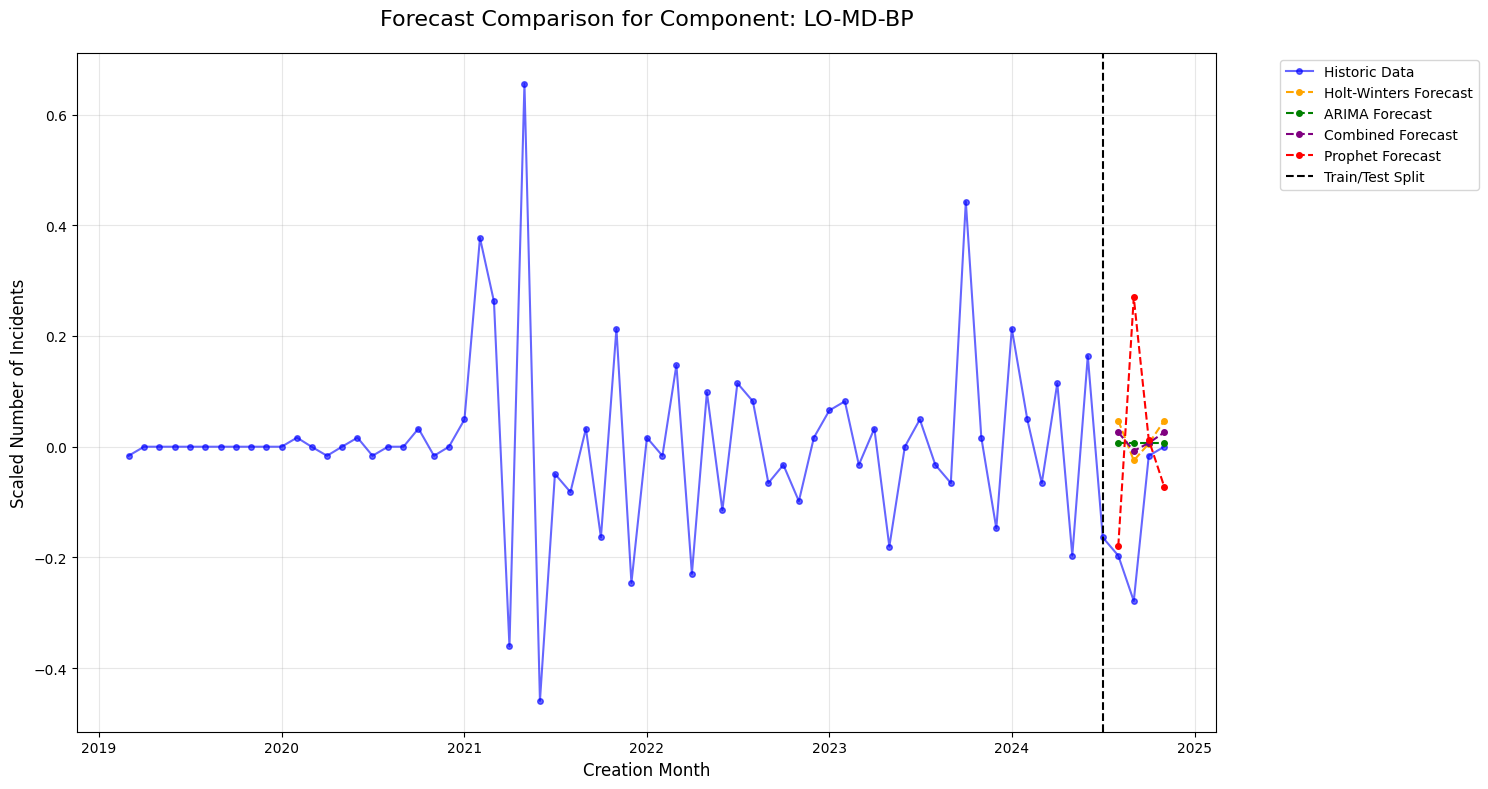


Validation Results for Component: LO-MD-BP

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4653
ARIMA Weight: 0.5347

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.0317
RMSE: 0.1779
MAE: 0.1418
MAPE: inf%
SMAPE: 191.8087%

Overfitting Analysis:
Train MAE: 0.1039
Validation MAE: 0.1167
Test MAE: 0.1418
Validation/Train Ratio: 1.1228
Test/Train Ratio: 1.3643
Status: Low risk of overfitting

ARIMA Model:
MSE: 0.0311
RMSE: 0.1763
MAE: 0.1305
MAPE: inf%
SMAPE: 200.0000%

Overfitting Analysis:
Train MAE: 0.0954
Validation MAE: 0.1015
Test MAE: 0.1305
Validation/Train Ratio: 1.0642
Test/Train Ratio: 1.3678
Status: Low risk of overfitting

Combined Model:
MSE: 0.0311
RMSE: 0.1763
MAE: 0.1358
MAPE: inf%
SMAPE: 197.3700%

Overfitting Analysis:
Train MAE: 0.0977
Validation MAE: 0.1082
Test MAE: 0.1358
Validation/Train Ratio: 1.1078
Test/Train Ratio: 1.3902
Status: Low risk of overfitting

Prophet Model:
MSE: 0.0767
RMSE: 0.2770
MAE: 0.1667
MAPE: nan%
SMAPE: nan%

Overfitting Analysis

16:43:17 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing
16:43:17 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing
16:43:17 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing
16:43:17 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing
16:43:17 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing
16:43:17 - cmdstanpy - INFO - Chain [1] start processing
16:43:17 - cmdstanpy - INFO - Chain [1] done processing


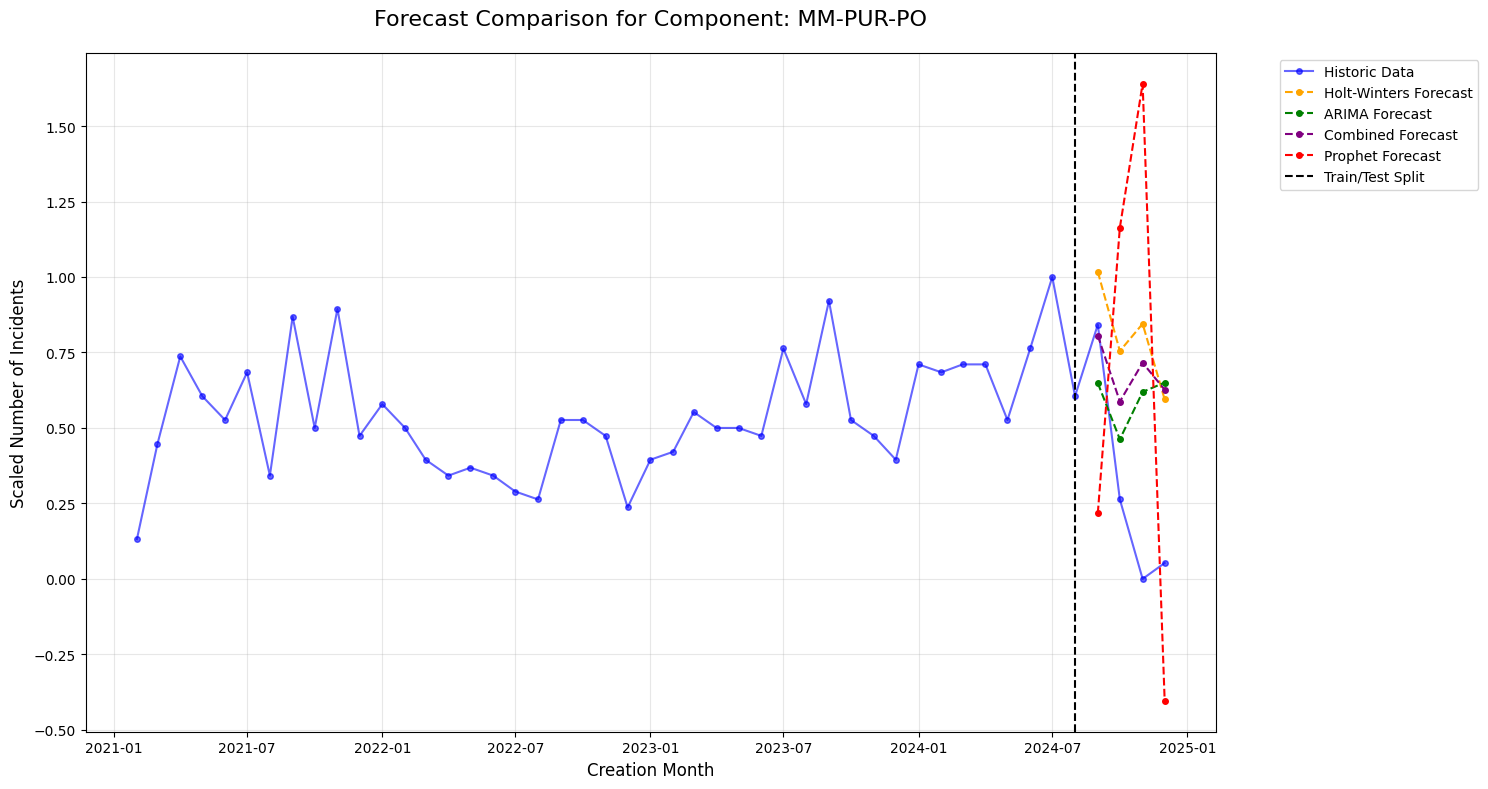


Validation Results for Component: MM-PUR-PO

Model Weights in Combined Forecast:
Holt-Winters Weight: 0.4277
ARIMA Weight: 0.5723

Accuracy Metrics:

Holt-Winters Model:
MSE: 0.3200
RMSE: 0.5657
MAE: 0.5133
MAPE: inf%
SMAPE: 120.7154%

Overfitting Analysis:
Train MAE: 0.2412
Validation MAE: 0.2173
Test MAE: 0.5133
Validation/Train Ratio: 0.9011
Test/Train Ratio: 2.1283
Status: High risk of overfitting

ARIMA Model:
MSE: 0.2045
RMSE: 0.4522
MAE: 0.4025
MAPE: inf%
SMAPE: 112.7426%

Overfitting Analysis:
Train MAE: 0.2027
Validation MAE: 0.1624
Test MAE: 0.4025
Validation/Train Ratio: 0.8013
Test/Train Ratio: 1.9857
Status: Moderate risk of overfitting

Combined Model:
MSE: 0.2371
RMSE: 0.4869
MAE: 0.4125
MAPE: inf%
SMAPE: 112.4072%

Overfitting Analysis:
Train MAE: 0.2168
Validation MAE: 0.1476
Test MAE: 0.4125
Validation/Train Ratio: 0.6807
Test/Train Ratio: 1.9031
Status: Moderate risk of overfitting

Prophet Model:
MSE: 1.0251
RMSE: 1.0125
MAE: 0.9056
MAPE: nan%
SMAPE: nan%

Overfitt

In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def main(data_file_path):
    """
    Main execution function for the incident analysis pipeline
    Parameters:
        data_file_path: Path to the incidents CSV file
    Returns:
        dict: Complete analysis results
    """
    # Phase 1-2: Data Collection and Preprocessing
    monthly_trends, top_components = load_and_preprocess_data(data_file_path)
    component_results = {}
    
    # Process each component
    for component in top_components:
        print(f"\n{'='*80}")
        print(f"\nAnalyzing Component: {component}")
        print(f"{'='*80}")
        
        # Prepare component data
        time_series_data, scaler = prepare_component_data(monthly_trends, component)
        
        # Check stationarity and prepare data
        if not check_stationarity(time_series_data):
            time_series_data = time_series_data.diff().dropna()
        
        # Split data
        overlap_months = min(4, len(time_series_data) // 5)
        val_size = len(time_series_data) // 3
        
        train_data = time_series_data.iloc[:-overlap_months]
        test_data = time_series_data.iloc[-overlap_months:]
        
        train_subset = train_data[:-val_size]
        val_data = train_data[-val_size:]
        
        # Phase 4: Model Training
        # Train Holt-Winters model
        hw_best_model, _ = train_holtwinters_model(train_data)
        hw_forecast = hw_best_model.forecast(overlap_months)
        hw_train_pred = hw_best_model.fittedvalues[-len(train_subset):]
        hw_val_pred = hw_best_model.forecast(len(val_data))
        
        # Train ARIMA model
        p_optimal, q_optimal = get_optimal_arima_orders(train_data)
        arima_best_model, _ = train_arima_model(train_data, p_optimal, q_optimal)
        arima_forecast = arima_best_model.forecast(steps=overlap_months)
        arima_train_pred = arima_best_model.fittedvalues[-len(train_subset):]
        arima_val_pred = arima_best_model.forecast(steps=len(val_data))
        
        # Train Prophet model
        prophet_data = train_data.reset_index()
        prophet_data.columns = ['ds', 'y']
        prophet_best_model, _ = train_prophet_model(prophet_data)
        
        if prophet_best_model is not None:
            future = pd.DataFrame({'ds': test_data.index})
            prophet_forecast = prophet_best_model.predict(future)
            prophet_overlap = prophet_forecast['yhat']
            
            train_prophet = pd.DataFrame({'ds': train_subset.index, 'y': train_subset.values})
            val_prophet = pd.DataFrame({'ds': val_data.index})
            prophet_train_pred = prophet_best_model.predict(train_prophet)['yhat']
            prophet_val_pred = prophet_best_model.predict(val_prophet)['yhat']
        
        # Phase 5: Model Validation
        # Calculate metrics for individual models
        hw_metrics = check_overfitting_metrics(
            train_subset[-len(hw_train_pred):], 
            val_data, 
            test_data,
            hw_train_pred,
            hw_val_pred,
            hw_forecast
        )
        
        arima_metrics = check_overfitting_metrics(
            train_subset[-len(arima_train_pred):],
            val_data,
            test_data,
            arima_train_pred,
            arima_val_pred,
            arima_forecast
        )
        
        if prophet_best_model is not None:
            prophet_metrics = check_overfitting_metrics(
                train_subset,
                val_data,
                test_data,
                prophet_train_pred,
                prophet_val_pred,
                prophet_overlap
            )
        
        # Generate combined forecast
        hw_weight, arima_weight = calculate_weights(hw_metrics['val_mae'], arima_metrics['val_mae'])
        combined_forecast = hw_forecast * hw_weight + arima_forecast * arima_weight
        combined_train_pred = hw_train_pred * hw_weight + arima_train_pred * arima_weight
        combined_val_pred = hw_val_pred * hw_weight + arima_val_pred * arima_weight
        
        combined_metrics = check_overfitting_metrics(
            train_subset[-len(combined_train_pred):],
            val_data,
            test_data,
            combined_train_pred,
            combined_val_pred,
            combined_forecast
        )
        
        # Calculate accuracy metrics
        hw_accuracy = calculate_accuracy_metrics(test_data, hw_forecast)
        arima_accuracy = calculate_accuracy_metrics(test_data, arima_forecast)
        combined_accuracy = calculate_accuracy_metrics(test_data, combined_forecast)
        if prophet_best_model is not None:
            prophet_accuracy = calculate_accuracy_metrics(test_data, prophet_overlap)
        
        # Visualize results
        validate_and_visualize_models(
            time_series_data, train_data, test_data,
            hw_forecast, arima_forecast, combined_forecast,
            prophet_overlap if prophet_best_model is not None else None,
            component
        )
        
        # Print validation results
        print_validation_results(
            component, hw_metrics, arima_metrics, combined_metrics,
            hw_accuracy, arima_accuracy, combined_accuracy,
            hw_weight, arima_weight,
            prophet_metrics if prophet_best_model is not None else None,
            prophet_accuracy if prophet_best_model is not None else None
        )
        
        # Store results
        component_results[component] = store_validation_results(
            component, hw_best_model, arima_best_model, prophet_best_model,
            hw_weight, arima_weight, hw_forecast, arima_forecast,
            prophet_overlap if prophet_best_model is not None else None,
            combined_forecast, hw_metrics, arima_metrics,
            prophet_metrics if prophet_best_model is not None else None,
            combined_metrics, hw_accuracy, arima_accuracy,
            prophet_accuracy if prophet_best_model is not None else None,
            combined_accuracy
        )
    
    return {
        'component_results': component_results,
        'top_components': top_components
    }

if __name__ == "__main__":
    # Execute the analysis pipeline
    results = main('Merged_Incidents.csv')
    
    # Print summary of results
    print("\nSummary of Results Across All Components:")
    print("="*80)
    
    for component in results['component_results']:
        print(f"\nComponent: {component}")
        print("-"*40)
        
        combined_metrics = results['component_results'][component]['accuracy']['combined_accuracy']
        print(f"Combined Model Performance:")
        print(f"RMSE: {combined_metrics['RMSE']:.4f}")
        print(f"MAE: {combined_metrics['MAE']:.4f}")
        print(f"MAPE: {combined_metrics['MAPE']:.4f}%")
        
        overfitting_status = results['component_results'][component]['metrics']['combined_metrics']['status']
        print(f"Overfitting Status: {overfitting_status}")
        print("-"*40)

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def basic_data_quality_checks(data):
    """
    Perform basic data quality checks on the incident data
    Parameters:
        data (pd.DataFrame): Raw incident data
    Returns:
        dict: Data quality metrics
    """
    quality_metrics = {
        'total_rows': len(data),
        'missing_values': data.isnull().sum().to_dict(),
        'duplicate_rows': len(data[data.duplicated()]),
        'components_count': data['Component'].nunique(),
        'date_range': {
            'start': data['Creation Month'].min(),
            'end': data['Creation Month'].max()
        }
    }
    return quality_metrics

def clean_incident_data(data):
    """
    Clean and standardize incident data
    Parameters:
        data (pd.DataFrame): Raw incident data
    Returns:
        pd.DataFrame: Cleaned data
    """
    cleaned_data = data.copy()
    
    # Handle missing values
    cleaned_data['Component'] = cleaned_data['Component'].fillna('Unknown')
    
    # Remove duplicates
    cleaned_data = cleaned_data.drop_duplicates()
    
    # Standardize component names (remove extra spaces, convert to title case)
    cleaned_data['Component'] = cleaned_data['Component'].str.strip().str.title()
    
    # Ensure dates are in correct format
    cleaned_data['Creation Month'] = pd.to_datetime(cleaned_data['Creation Month'])
    
    # Sort by date
    cleaned_data = cleaned_data.sort_values('Creation Month')
    
    return cleaned_data

def handle_outliers(data, column, method='iqr', threshold=1.5):
    """
    Handle outliers in specified column
    Parameters:
        data (pd.DataFrame): Input data
        column (str): Column name to check for outliers
        method (str): Method to use ('iqr' or 'zscore')
        threshold (float): Threshold for outlier detection
    Returns:
        pd.DataFrame: Data with outliers handled
    """
    if method == 'iqr':
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Cap outliers instead of removing them
        data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)
        
    elif method == 'zscore':
        z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
        data[column] = data[column].mask(z_scores > threshold, data[column].median())
    
    return data

def aggregate_incidents(data, freq='M'):
    """
    Aggregate incidents by time period and component
    Parameters:
        data (pd.DataFrame): Cleaned incident data
        freq (str): Frequency for aggregation ('M' for monthly, 'W' for weekly)
    Returns:
        pd.DataFrame: Aggregated incident counts
    """
    # Group by time period and component
    aggregated = data.groupby([
        pd.Grouper(key='Creation Month', freq=freq),
        'Component'
    ])['Incident'].count().reset_index()
    
    # Pivot to get components as columns
    pivoted = aggregated.pivot(
        index='Creation Month',
        columns='Component',
        values='Incident'
    ).fillna(0)
    
    return pivoted

def load_and_preprocess_data(file_path):
    """
    Load and preprocess the incident data from CSV file
    Parameters:
        file_path (str): Path to the incidents CSV file
    Returns:
        pd.DataFrame: Preprocessed monthly trends data
        list: Top 10 components by incident count
        dict: Data quality metrics
    """
    # Load data
    print("Loading data...")
    data = pd.read_csv(file_path)
    
    # Perform data quality checks
    print("Performing data quality checks...")
    quality_metrics = basic_data_quality_checks(data)
    
    # Clean data
    print("Cleaning data...")
    cleaned_data = clean_incident_data(data)
    
    # Group and aggregate data
    print("Aggregating data...")
    monthly_trends = cleaned_data.groupby(['Creation Month', 'Component'])['Incident'].count().reset_index()
    
    # Handle outliers in incident counts
    print("Handling outliers...")
    monthly_trends = handle_outliers(monthly_trends, 'Incident', method='iqr')
    
    # Calculate component totals
    component_growth = monthly_trends.groupby('Component')['Incident'].sum().reset_index()
    component_growth.columns = ['Component', 'Total Incidents']
    
    # Get top 10 components
    top_components = component_growth.nlargest(10, 'Total Incidents')['Component'].tolist()
    
    print("Data preprocessing completed.")
    return monthly_trends, top_components, quality_metrics

def prepare_component_data(monthly_trends, component, scaler=None):
    """
    Prepare time series data for a specific component
    Parameters:
        monthly_trends (pd.DataFrame): Monthly incident trends data
        component (str): Component name to analyze
        scaler (sklearn.preprocessing.MinMaxScaler, optional): Scaler for normalization
    Returns:
        pd.Series: Processed time series data
        sklearn.preprocessing.MinMaxScaler: Fitted scaler
    """
    # Filter data for current component
    component_data = monthly_trends[monthly_trends['Component'] == component]
    
    # Ensure complete monthly data (fill gaps)
    date_range = pd.date_range(
        component_data['Creation Month'].min(),
        component_data['Creation Month'].max(), 
        freq='MS'
    )
    component_data = component_data.set_index('Creation Month').reindex(date_range, fill_value=0)
    component_data.index.name = 'Creation Month'
    
    # Apply smoothing to handle noise
    component_data['Smoothed_Incident'] = component_data['Incident'].rolling(
        window=3,
        center=True,
        min_periods=1  # Ensure we don't lose data at endpoints
    ).mean()
    
    # Fill NaN values from smoothing
    component_data['Incident'] = component_data['Incident'].fillna(component_data['Smoothed_Incident'])
    
    # Scale the data
    if scaler is None:
        scaler = MinMaxScaler()
    component_data['Scaled_Incident'] = scaler.fit_transform(component_data[['Incident']])
    
    return component_data['Scaled_Incident'], scaler

def generate_preprocessing_report(file_path):
    """
    Generate a comprehensive preprocessing report
    Parameters:
        file_path (str): Path to the incidents CSV file
    Returns:
        dict: Preprocessing report
    """
    # Load and preprocess data
    monthly_trends, top_components, quality_metrics = load_and_preprocess_data(file_path)
    
    # Generate report
    report = {
        'data_quality_metrics': quality_metrics,
        'top_components': {
            'components': top_components,
            'incident_counts': monthly_trends[monthly_trends['Component'].isin(top_components)]
                             .groupby('Component')['Incident'].sum().to_dict()
        },
        'time_range': {
            'start': monthly_trends['Creation Month'].min(),
            'end': monthly_trends['Creation Month'].max(),
            'total_months': monthly_trends['Creation Month'].nunique()
        },
        'preprocessing_steps_applied': [
            'Removed duplicate entries',
            'Standardized component names',
            'Handled missing values',
            'Removed outliers using IQR method',
            'Applied 3-month rolling average smoothing',
            'Scaled incident counts to 0-1 range'
        ]
    }
    
    return report

# Example usage
if __name__ == "__main__":
    file_path = 'Merged_Incidents.csv'
    
    # Generate preprocessing report
    report = generate_preprocessing_report(file_path)
    
    # Print report
    print("\nPreprocessing Report:")
    print("="*80)
    print(f"\nData Quality Metrics:")
    for metric, value in report['data_quality_metrics'].items():
        print(f"{metric}: {value}")
    
    print(f"\nTop Components by Incident Count:")
    for component, count in report['top_components']['incident_counts'].items():
        print(f"{component}: {count}")
    
    print(f"\nTime Range:")
    print(f"Start: {report['time_range']['start']}")
    print(f"End: {report['time_range']['end']}")
    print(f"Total Months: {report['time_range']['total_months']}")
    
    print(f"\nPreprocessing Steps Applied:")
    for step in report['preprocessing_steps_applied']:
        print(f"- {step}")

Loading data...
Performing data quality checks...
Cleaning data...
Aggregating data...
Handling outliers...
Data preprocessing completed.

Preprocessing Report:

Data Quality Metrics:
total_rows: 118697
missing_values: {'Incident ID Raw': 0, 'Incident ID': 0, 'Incident': 0, 'Description': 5, 'Number': 118697, 'Year': 118697, 'CSS NG Follow Up': 118697, 'Customer Category': 10, 'Customer': 10, 'Customer Name': 10, 'Int. Acc. Class.': 1024, 'Global Ultimate ID': 0, 'Global Ultimate': 10, 'Sales Region': 18230, 'Country/Region': 10, 'Premium Contract': 59516, 'Service Product ID': 59516, 'Support Delivery Model': 295, 'S/4HC Planned Go-Live': 59352, 'S/4HC Live (Day)': 66803, 'S/4HC Live (Month)': 66344, 'Processor ID': 44766, 'Processor': 44767, 'Resp. Vice President (Incident)': 90869, 'Resp. Vice President (Component)': 2410, 'Resp. Vice President (Development)': 2176, 'Resp. Vice President (IMS)': 77056, 'Dev. Manager': 2744, 'Dev. Product Owner': 44996, 'Dev. Area Product Owner': 681

In [1]:
import pandas as pd

def convert_all_to_string(input_file, output_file=None):
    """
    Convert all columns in a CSV file to string type.
    
    Parameters:
    input_file (str): Path to the input CSV file
    output_file (str, optional): Path to save the output CSV file. If None, overwrites the input file.
    
    Returns:
    pd.DataFrame: DataFrame with all columns converted to strings
    """
    # Read the CSV file
    print(f"Reading CSV file: {input_file}")
    df = pd.read_csv(input_file)
    
    # Print original data types
    print("\nOriginal data types:")
    print(df.dtypes)
    
    # Convert all columns to string
    for column in df.columns:
        df[column] = df[column].astype(str)
    
    # Print new data types
    print("\nNew data types (all strings):")
    print(df.dtypes)
    
    # Save to output file
    if output_file is None:
        output_file = input_file
    
    df.to_csv(output_file, index=False)
    print(f"\nSaved string-converted data to: {output_file}")
    
    return df

# Example usage
if __name__ == "__main__":
    # Change this to your actual file path
    input_csv = "DataDictionary.csv"
    output_csv = "DataDictionary_string.csv"  # Optional: set to None to overwrite original
    
    converted_df = convert_all_to_string(input_csv, output_csv)
    
    # Show sample of converted data
    print("\nSample of converted data:")
    print(converted_df.head())

Reading CSV file: DataDictionary.csv

Original data types:
SoldToParty            object
Organization           object
Material               object
Customer               object
Product                object
TransactionCurrency    object
Supplier               object
dtype: object

New data types (all strings):
SoldToParty            object
Organization           object
Material               object
Customer               object
Product                object
TransactionCurrency    object
Supplier               object
dtype: object


/var/folders/sw/j578l42n4_v0q0r1vyd70kr00000gn/T/ipykernel_86679/2695277856.py:16: DtypeWarning: Columns (0,1,3,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)



Saved string-converted data to: DataDictionary_string.csv

Sample of converted data:
  SoldToParty Organization Material  Customer Product TransactionCurrency  \
0    10100001         1010     RM16  10100001    RM16                 EUR   
1    10100001         2010     RM16  10100001    RM16                 EUR   
2    10100060         1010     T999  10100060    T999                 EUR   
3    10100009         1010    QM005  10100009   QM005                 EUR   
4    10100081         1010   NS0001  10100081  NS0001                 EUR   

   Supplier  
0  10100001  
1  10100001  
2  10100060  
3  10100009  
4  10100081  
